In [1]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [2]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
skills = dict(zip(skills.index, skills.values))

In [4]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
certs = dict(zip(certs.index, certs.values))

In [6]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [7]:
licenses = dict(zip(licenses.index, licenses.values))

In [8]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
languages = dict(zip(languages.index, languages.values))

In [10]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,90
84612,48
84731,3766
85437,3812
85627,1556


In [11]:
addresses = dict(zip(addresses.index, addresses.values))

In [12]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [13]:
df_pred = pd.read_csv("../Data/df_pred.csv").drop("Unnamed: 0", axis=1)

In [14]:
df_pred.head()

,candidate_id,job_order,time_between,time_spent,isco_functie_niveau,education,function_id,isco_code4
0,84556,0,37,156,2.0,0.0,937.0,207.0
1,84556,1,23,116,1.0,0.0,811.0,347.0
2,84556,2,23,275,2.0,0.0,937.0,207.0
3,84556,3,1155,4,1.0,0.0,1521.0,343.0
4,84556,4,203,11,1.0,0.0,1521.0,343.0


In [15]:
career_paths = df_pred.groupby("candidate_id")

In [16]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(354, 7)

In [17]:
maximum_career_duration = 25

In [18]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 465468/465468 [00:50<00:00, 9135.03it/s] 


In [19]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [20]:
career_paths.head()

candidate_id
84556    [[0.0, 37.0, 156.0, 2.0, 0.0, 937.0, 207.0], [...
84612    [[0.0, 2537.0, 6.0, 1.0, 0.0, 1521.0, 343.0], ...
84731    [[0.0, 46.0, 23.0, 1.0, 0.0, 1521.0, 343.0], [...
85437    [[0.0, 747.0, 670.0, 1.0, 2.0, 1521.0, 343.0],...
85627    [[0.0, 140.0, 4627.0, 3.0, 0.0, 1922.0, 155.0]...
dtype: object

In [21]:
idxs = []
x = []
y = []

candidate_lens = defaultdict(int)

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, 6]
    
    if not np.isnan(label):
        candidate_lens[idx] = len(career) - 1
        
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [22]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [23]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [24]:
del df_pred
del x

In [25]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [26]:
len(to_fill), len(y)

(265647, 265647)

In [27]:
# to_fill = to_fill[:75000]
# y = y[:75000]

In [28]:
# Train test split
split = 0.8
random.seed(42)

training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
test = np.array(list(set(range(len(to_fill))) - set(training)))

train_indices, val_indices = idxs[training], idxs[test]
X_train, X_val = to_fill[training], to_fill[test]
y_train, y_val = y[training].astype(int), y[test].astype(int)

In [29]:
# Class weights
counts = np.bincount(y_train) + 1
labels_weights = 1. / counts
weights = labels_weights[y_train]
sampler = WeightedRandomSampler(weights, len(weights))

# Create dataloaders
train_data = TensorDataset(torch.Tensor(train_indices), 
                           torch.Tensor(X_train), 
                           torch.Tensor(y_train).type(torch.LongTensor))

trainloader = DataLoader(train_data, batch_size=512, sampler=sampler)

val_data = TensorDataset(torch.Tensor(val_indices),
                         torch.Tensor(X_val),
                         torch.Tensor(y_val).type(torch.LongTensor))

valloader = DataLoader(val_data, batch_size=512, shuffle=True)

In [50]:
class CNN_LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, 
                 num_layers, skills, certs, licenses, languages, 
                 addresses, w2v, candidate_lengths, max_len, 
                 skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3):
        
        super(CNN_LSTM, self).__init__()
              
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size + 300
        self.hidden_size = hidden_size
        self.softmax = nn.LogSoftmax(dim=-1)
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4757, address_embedding_size)       
        
        # Categorical feature embeddings
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
        
        self.conv32 = nn.Conv1d(384, 32, 3, stride=1, padding=1)
        self.conv64 = nn.Conv1d(32, 64, 3, stride=1, padding=1)
        self.maxpooling = nn.MaxPool1d(2)
    
        self.lstm = nn.LSTM(input_size=max_len // 2,
                            hidden_size=hidden_size,
                            num_layers=1,
                            batch_first=True)
            
            
        # Final fully-connected layer takes the LSTM output, as well as the static embeddings
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Skill lookup
        self.skill_keys = set(skills.keys())
        self.skills = np.vectorize(skills.get)
        
        # Certificate lookup
        self.certs_keys = set(certs.keys())
        self.certs = np.vectorize(certs.get)
        
        # License lookup
        self.license_keys = set(licenses.keys())
        self.licenses = np.vectorize(licenses.get)
        
        # Language lookup
        self.langs_keys = set(languages.keys())
        self.langs = np.vectorize(languages.get)
        
        # Address lookup
        self.address_keys = set(addresses.keys())
        self.adds = np.vectorize(addresses.get)
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len        
                
    def static_lookup(self, candidate):
        """Looks up a candidate's static features (skills, certificates)"""
         # Look up skills            
        if candidate.item() in self.skill_keys:
            skill_list = torch.LongTensor(self.skills(candidate.item())).to(device)
        else:
            skill_list = torch.LongTensor([0] * 317).to(device)

        # Look up certificates
        if candidate.item() in self.certs_keys:
            certs_list = torch.LongTensor(self.certs(candidate.item())).to(device)
        else:
            certs_list = torch.LongTensor([0] * 98).to(device)
            
        # Look up certificates
        if candidate.item() in self.license_keys:
            license_list = torch.LongTensor(self.licenses(candidate.item())).to(device)
        else:
            license_list = torch.LongTensor([0] * 8).to(device)
        
        # Look up certificates
        if candidate.item() in self.langs_keys:
            langs_list = torch.LongTensor(self.langs(candidate.item())).to(device)
        else:
            langs_list = torch.LongTensor([0] * 23).to(device)
            
        # Look up address
        if candidate.item() in self.address_keys:
            address = torch.LongTensor(self.adds(candidate.item())).to(device)
        else:
            address = torch.LongTensor([0]).to(device)
            
        return skill_list, certs_list, license_list, langs_list, address
    
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= self.max_len])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()
                if durations[-1] == -1: # Sometimes contains -1 --> last location > (career duration)?
                    durations.pop()
                    durations[-1] -= 1
                    # In case the last one should be ignored completely
                    if durations[-1] == 0:
                        durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        storage.append(torch.stack([torch.Tensor(embed_values[i])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
 
    def forward(self, candidate, x):               
        # Default width of a row (filled with 0s)
        cv_width = torch.Tensor([0] * 300).type(torch.LongTensor).to(device)
        
        candidate_cvs = []
        candidate_static = []
        candidate_address = []
                
        # For each candidate in the current batch
        for c in candidate:
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]            
            
            # Get skills and certificates
            skill_list, certs_list, license_list, langs_list, address = self.static_lookup(c)
            
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([cv_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                
            # Embed every static feature
            skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                                self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                                self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                                self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
                
            # Combine and embed
            static_features = torch.cat([skill_list, certs_list, 
                                         license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
            address_emb = self.address_embedding(address)
                        
            # Broadcast CV to the correct length
            cv_features = torch.cat([zeros, w2v_list], dim=0)
                    
            # Store result
            candidate_cvs.append(cv_features)
            candidate_static.append(static_features)
            candidate_address.append(address_emb[0])
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_cvs)).type(torch.FloatTensor).to(device)
        
        # TODO: categorical features in x --> embed
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, education, function_id, isco_code = [x[:,:,-4],
                                                         x[:,:,-3],
                                                         x[:,:,-2],
                                                         x[:,:,-1]]
        
        x = x[:,:,:-4]

        
        isco_level, education, function_id, isco_code = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)),
                                                         self.education_embedding(education.type(torch.LongTensor).to(device)),
                                                         self.function_embedding(function_id.type(torch.LongTensor).to(device)),
                                                         self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device))]
                
        
        
        # Add features
        x = torch.cat([x, isco_level, education, function_id, isco_code, additional_features], dim=2)
        
        x = x.transpose(1, 2)

        # TODO: add static features by broadcasting
        # static = torch.stack((candidate_static)).type(torch.FloatTensor).to(device)
        # address = torch.stack((candidate_address)).type(torch.FloatTensor).to(device)
        
        # combine with embedding
        # x = torch.cat([h_out, static, address], dim=1)
                
        # Forward pass
        x = self.conv32(x)
        x = self.conv64(x)
        x = self.maxpooling(x)
                
        _, (h_n, _) = self.lstm(x)
        
        x = h_n.view(-1, self.hidden_size)    
        
        # Fully-connected
        out = self.fc(x)
    
        # softmax
        out = self.softmax(out)
                        
        return out, weights

In [51]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        for i, (candidate, career, job) in enumerate(trainloader):
            
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs, weights = model(candidate, career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
               
        stats = test_loop(valloader, model, criterion)
        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        
        scheduler.step()
        
        print(f"Epoch duration: {int((time.time() - start) // 60)}:{int((time.time() - start) % 60)}\n")
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            pred, weights = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
#         a = weights[0].cpu().detach().numpy().mean(axis=0)            
#         plt.plot(a, label="average")
#         plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
#         plt.xlabel("Career step")
#         plt.ylabel("Attention weight")
#         plt.show()
 
            
    # print("\nValidation:", Counter(np.array(pred.argmax(1).cpu())))
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [52]:
torch.cuda.empty_cache()

In [53]:
num_epochs = 15
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4][2:]
num_layers_values = [1, 5, 10]
hidden_sizes = [500, 1000][1:]

try:            
    for learning_rate in learning_rates:
        for num_layers in num_layers_values:
            for hidden_size in hidden_sizes:

                lstm = CNN_LSTM(num_classes=num_classes,
                                input_size=num_features,
                                num_layers=num_layers,
                                hidden_size=hidden_size,
                                skills=skills, 
                                certs=certs,
                                licenses=licenses,
                                languages=languages,
                                addresses=addresses,
                                w2v=w2v,
                                address_embedding_size=25,
                                candidate_lengths=candidate_lens,
                                max_len=max_len)

                lstm = lstm.to(device)

                optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

                print(f"Current iteration {current}/{len(learning_rates) * len(num_layers_values) * len(hidden_sizes)}")
                print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", lstm, "\n")

                # Store results of current configuration
                outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                outcome["lr"] = [learning_rate] * num_epochs
                outcome["Number of layers"] = [num_layers] * num_epochs
                outcome["Nodes per layer"] = [hidden_size] * num_epochs

                full_results.append(outcome)

                current += 1
            break

        # We ignore LR for now
        break
except KeyboardInterrupt:
    pass

Current iteration 0/6
- Initial learning rate: 0.001
- Model: 

 CNN_LSTM(
  (softmax): LogSoftmax()
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2992, 50)
  (isco_code_embedding): Embedding(354, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (conv32): Conv1d(384, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv64): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(12, 1000, batch_first=True)
  (fc): Linear(in_features=1000, out_features=354, bias=True)
) 

--------------------------------------------

In [ ]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Number of layers", "Nodes per layer", "Epoch"])

In [ ]:
total

Batch accuracy: 0.421875


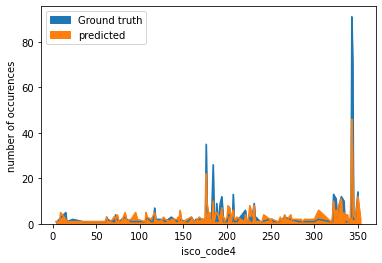

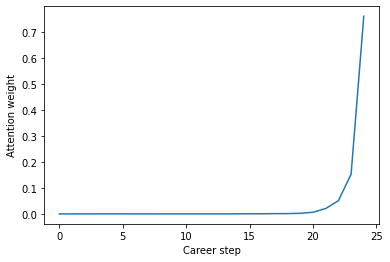

In [63]:
with torch.no_grad():
    for candidate, career, job in valloader:
        candidate, career, job = candidate.to(device), career.to(device), job.to(device)
        pred, weights = lstm(candidate, career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())        
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        plt.show()
        a = weights[0].cpu().detach().numpy().mean(axis=0)            
        plt.plot(a, label="average")
        # plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
        plt.xlabel("Career step")
        plt.ylabel("Attention weight")
        plt.show()
        
        break

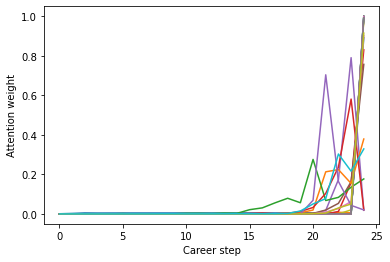

In [61]:
b = weights[0].cpu().detach().numpy()

for _ in range(20):
    c = np.random.randint(0, len(b))
    plt.plot(b[c])
    plt.xlabel("Career step")
    plt.ylabel("Attention weight")